In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
import datetime
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

Load and clean the dataset

In [3]:
data = pd.read_csv('/content/marketing_campaign.csv', sep="\t")
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   int64 

Feature Engineering:

In [5]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True, errors='coerce')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)


<ipython-input-5-0c6ebe15709b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], dayfirst=True, errors='coerce')


In [6]:
days = []
d1 = max(dates) + datetime.timedelta(days=1)
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")
data["Age"] = 2024 - data["Year_Birth"]
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]
data["Living_With"] = data["Marital_Status"].replace({"Married": "Partner", "Together": "Partner", "Absurd": "Alone", "Widow": "Alone", "YOLO": "Alone", "Divorced": "Alone", "Single": "Alone"})
data["Children"] = data["Kidhome"] + data["Teenhome"]
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}) + data["Children"]
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)
data["Education"] = data["Education"].replace({"Basic": "Undergraduate", "2n Cycle": "Undergraduate", "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"})
data['RFM_Score'] = (data['Recency'] + data['NumDealsPurchases'] + data['Spent']) / 3
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)


<ipython-input-6-95472588ee73>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Customer_For"] = days
<ipython-input-6-95472588ee73>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")
<ipython-input-6-95472588ee73>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

In [7]:
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent,RFM_Score
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.013538,0.009477,0.150271,3.063063e+16,55.179603,607.075361,0.947202,2.592509,0.714350,219.470517
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.115588,0.096907,0.357417,1.749036e+16,11.985554,602.900476,0.749062,0.905722,0.451825,201.350602
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,8.640000e+13,28.000000,5.000000,0.000000,1.000000,0.000000,3.333333
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,1.563840e+16,47.000000,69.000000,0.000000,2.000000,0.000000,43.250000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,3.080160e+16,54.000000,396.500000,1.000000,3.000000,1.000000,145.666667
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,4.579200e+16,65.000000,1048.000000,1.000000,3.000000,1.000000,365.750000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,6.048000e+16,131.000000,2525.000000,3.000000,5.000000,1.000000,862.333333


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

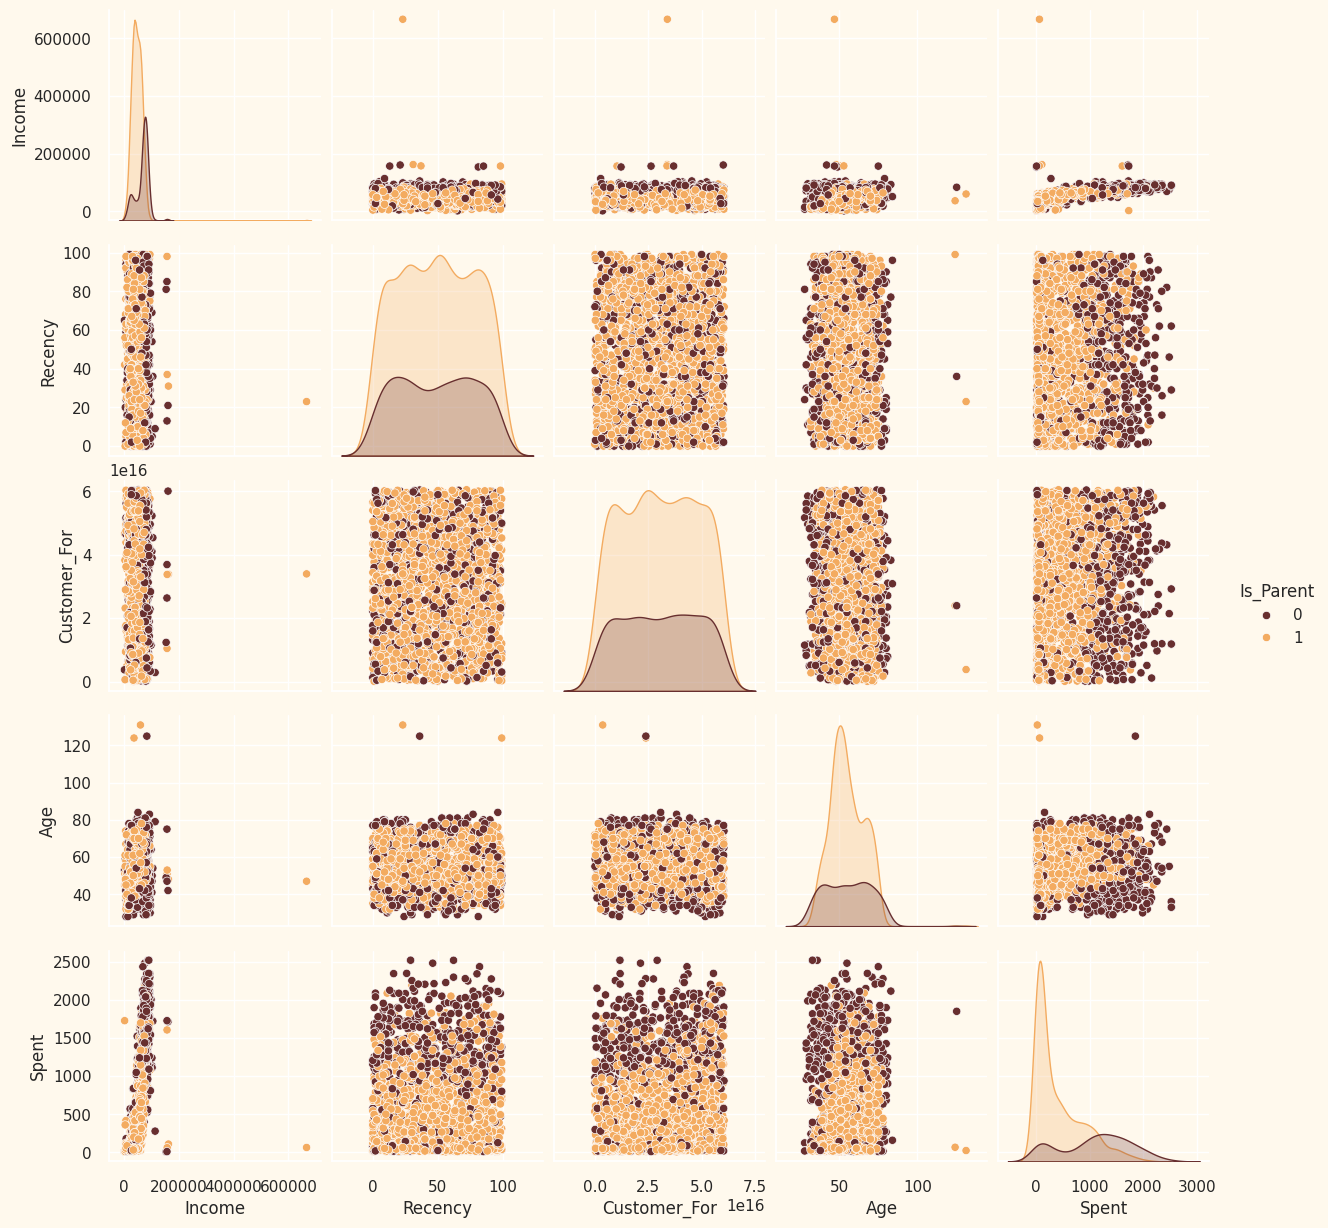

In [8]:
#To plot some selected features
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

Removing outliers:

In [9]:
from scipy import stats
z_scores = np.abs(stats.zscore(data[['Recency', 'Spent', 'NumDealsPurchases']]))
data = data[(z_scores < 3).all(axis=1)]

Scaling features:

In [10]:
features_to_scale = ["Income", "Recency", "Customer_For", "Age", "Spent", "Children", "Family_Size", 'RFM_Score']
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

<ipython-input-10-371b47251caa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features_to_scale] = scaler.fit_transform(data[features_to_scale])


In [11]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,RFM_Score
0,Graduate,0.240816,0,0,0.306012,635,88,546,172,88,...,0,1,1.540800,0.987621,1.702608,Alone,-1.263982,-1.760643,0,1.715580
1,Graduate,-0.230827,1,1,-0.385325,11,1,6,2,1,...,0,0,-1.181361,1.237982,-0.957773,Alone,1.433503,0.465047,1,-0.974942
2,Graduate,0.779681,0,0,-0.800128,426,49,127,111,21,...,0,0,-0.196434,0.319994,0.295450,Partner,-1.263982,-0.647798,0,0.254247
3,Graduate,-1.018550,1,0,-0.800128,11,4,20,10,3,...,0,0,-1.052677,-1.265621,-0.914270,Partner,0.084760,0.465047,1,-0.951561
4,Postgraduate,0.247014,1,0,1.550419,173,43,118,46,27,...,0,0,-0.943791,-1.015261,-0.296861,Partner,0.084760,0.465047,1,-0.216719


PCA for dimensionality reduction:

In [12]:
label_cols = ['Education', 'Living_With']
LE = LabelEncoder()
for col in label_cols:
    data[col] = LE.fit_transform(data[col])

<ipython-input-12-817d3a1fe324>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = LE.fit_transform(data[col])
<ipython-input-12-817d3a1fe324>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = LE.fit_transform(data[col])


In [68]:
pca = PCA(n_components=3)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
PCA_ds = pd.DataFrame(pca.fit_transform(scaled_data), columns=["PC1", "PC2", "PC3"])
X = PCA_ds

# Step 5: Apply clustering algorithms and calculate silhouette scores

# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_clusters)
print(f"KMeans Silhouette Score: {kmeans_silhouette}")
pca_components = pd.DataFrame(pca.components_, columns=data.columns, index=['PC1', 'PC2', 'PC3'])

print("PCA Components (Feature Contributions):")
print(pca_components)

# Step 4: Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"\nExplained Variance Ratio: {explained_variance}")

KMeans Silhouette Score: 0.3801602308056966
PCA Components (Feature Contributions):
     Education    Income   Kidhome  Teenhome   Recency  MntWines  MntFruits  \
PC1  -0.026432  0.225844 -0.222381 -0.083137  0.001848  0.252092   0.215334   
PC2  -0.052710  0.109315 -0.028786  0.422586  0.036271  0.148869   0.019576   
PC3   0.014270  0.010106  0.139504  0.049385 -0.056954  0.210371  -0.147820   

     MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Response  \
PC1         0.269392         0.225666          0.216163  ...  0.088977   
PC2        -0.032745         0.001767          0.013791  ... -0.098099   
PC3        -0.013501        -0.142218         -0.114327  ...  0.381483   

     Customer_For       Age     Spent  Living_With  Children  Family_Size  \
PC1      0.034526  0.038081  0.303871    -0.022553 -0.221835    -0.195045   
PC2      0.106834  0.184570  0.084837     0.097349  0.288217     0.289648   
PC3      0.111749 -0.029200  0.079499     0.026305  0.137137     0.1271

Elbow method for k-means to find the optimum number of clusters:

Elbow Method to determine the number of clusters:


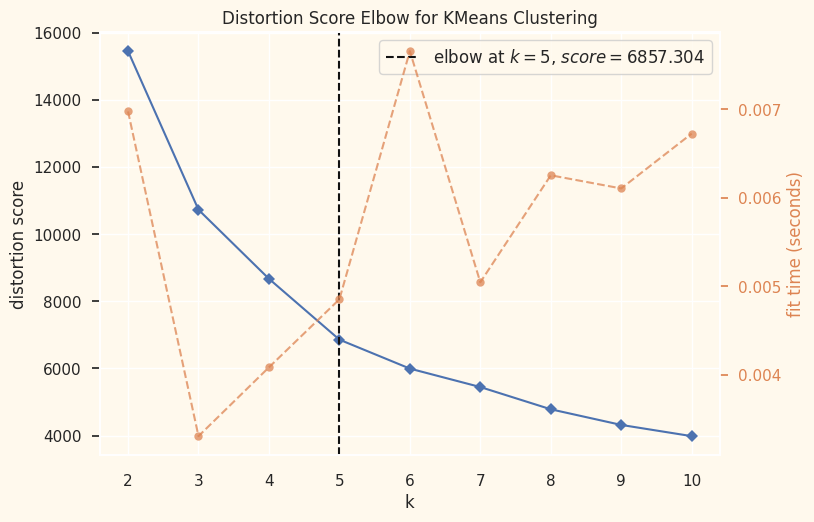

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
print('Elbow Method to determine the number of clusters:')
elbow_visualizer = KElbowVisualizer(KMeans(), k=10)
elbow_visualizer.fit(PCA_ds)
elbow_visualizer.show()

Applying K-Means Clustering:

In [53]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
X = PCA_ds
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data['Clusters'] = kmeans.fit_predict(PCA_ds)

Visualising clusters in 3D:

<ipython-input-54-13c69555dbaf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data['Clusters'], palette="Set2")


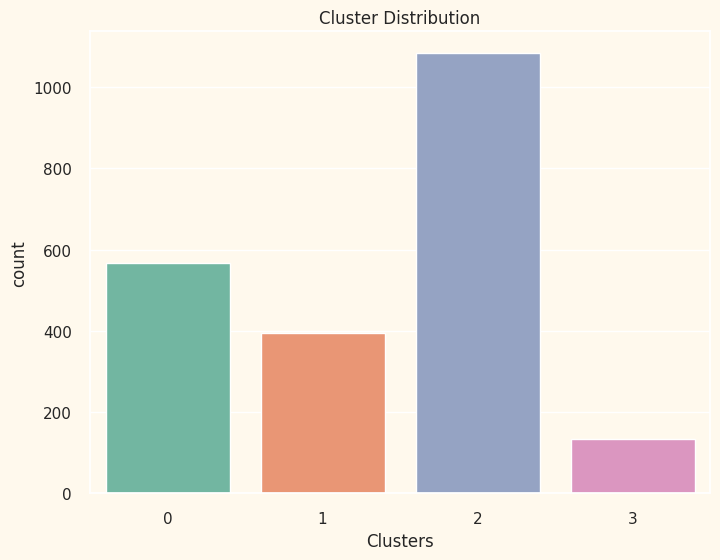

In [54]:
plt.figure(figsize=(8, 6))
sns.countplot(x=data['Clusters'], palette="Set2")
plt.title("Cluster Distribution")
plt.show()

Profiling Clusters based on personal attributes:

<Figure size 800x550 with 0 Axes>

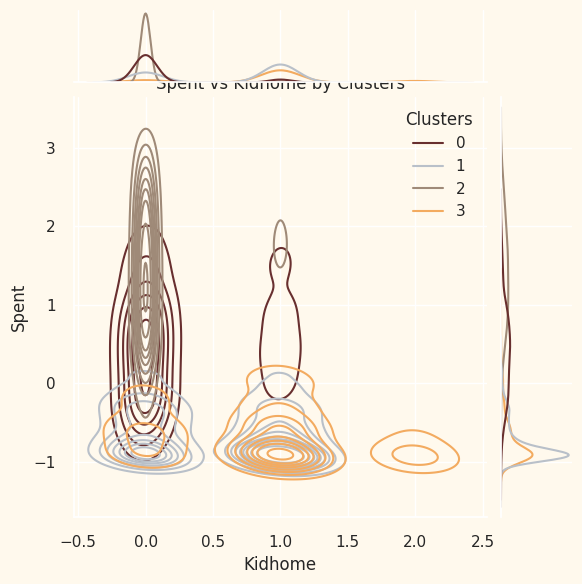

<Figure size 800x550 with 0 Axes>

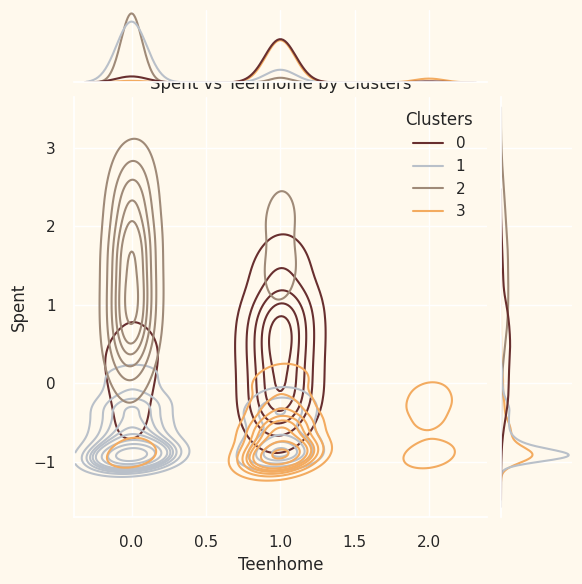

<Figure size 800x550 with 0 Axes>

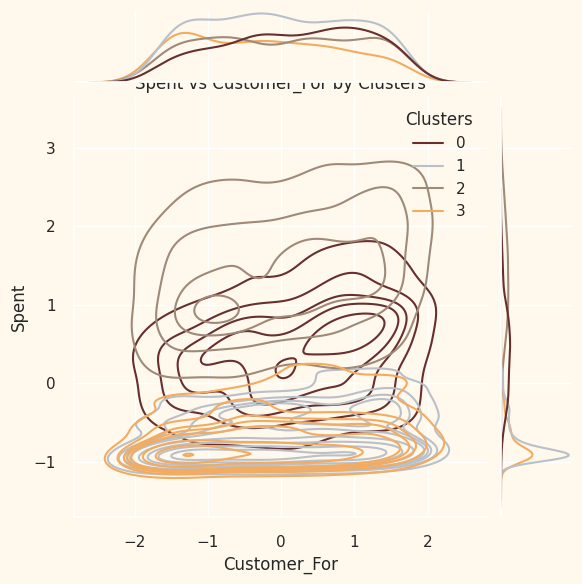

<Figure size 800x550 with 0 Axes>

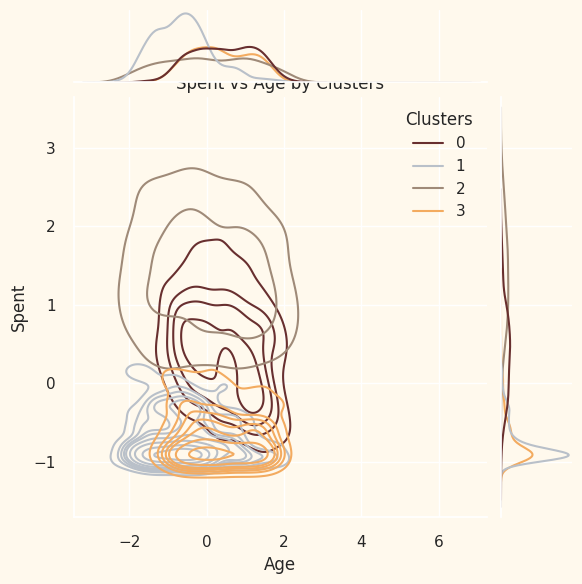

<Figure size 800x550 with 0 Axes>

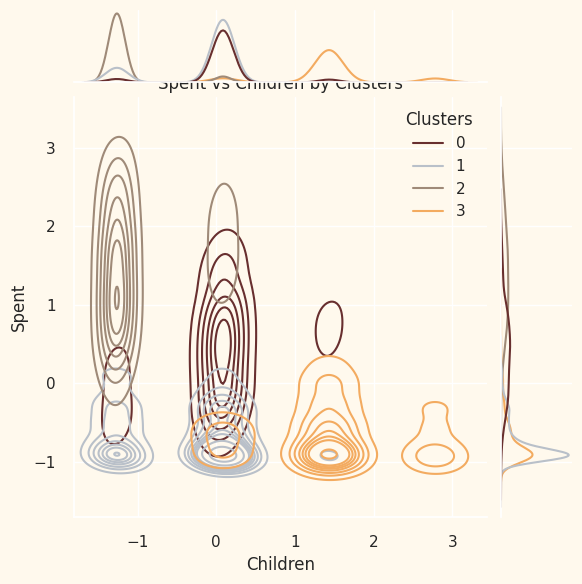

<Figure size 800x550 with 0 Axes>

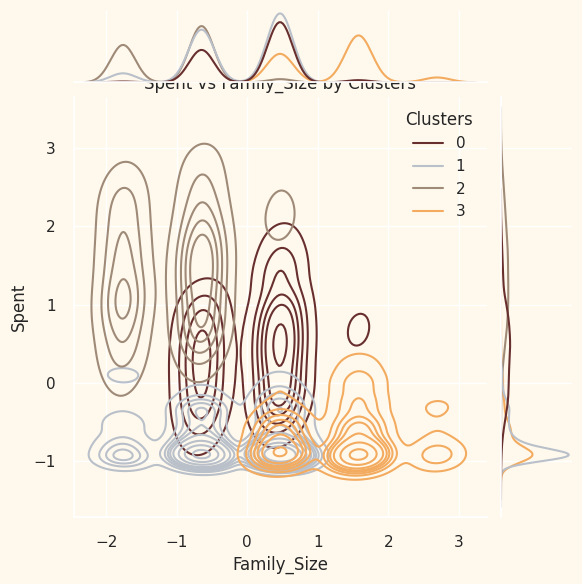

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

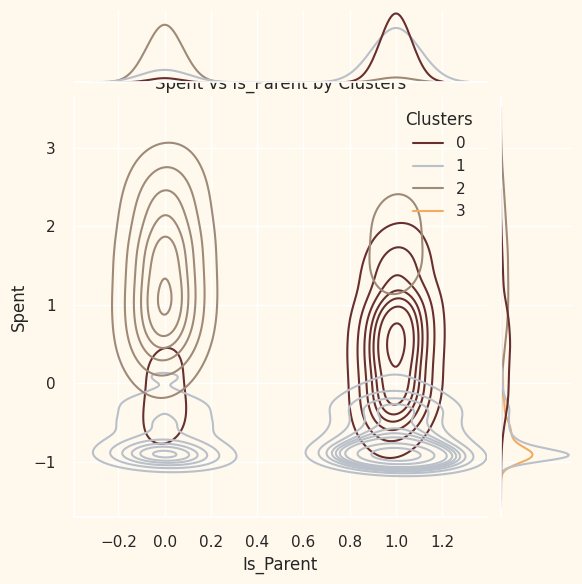

<Figure size 800x550 with 0 Axes>

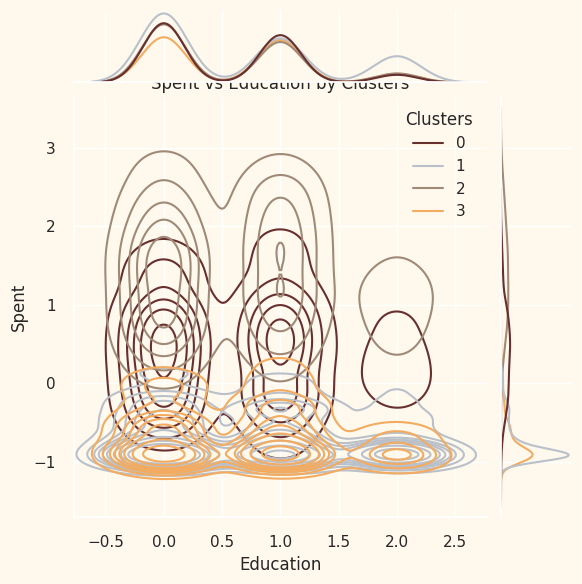

<Figure size 800x550 with 0 Axes>

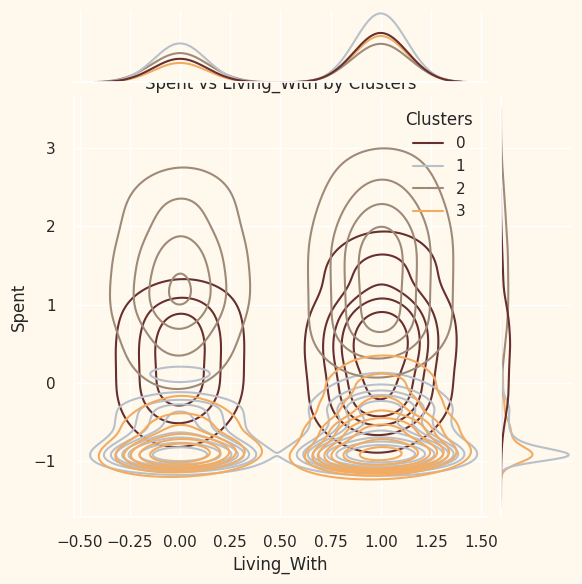

In [45]:
pal = ["#682F2F", "#B9C0C9", "#9F8A78", "#F3AB60"]
Personal = ["Kidhome", "Teenhome", "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education", "Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue=data["Clusters"], kind="kde", palette=pal)
    plt.title(f"Spent vs {i} by Clusters")
    plt.show()

Visualising cluster distribution:

<ipython-input-55-0b7e129cb20e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette=pal)


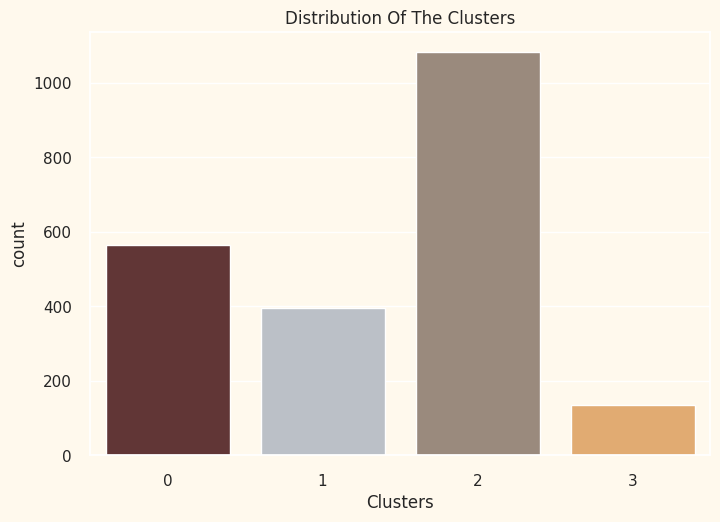

In [55]:
plt.figure()
pl = sns.countplot(x=data["Clusters"], palette=pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

Visualising Spending Patterns:

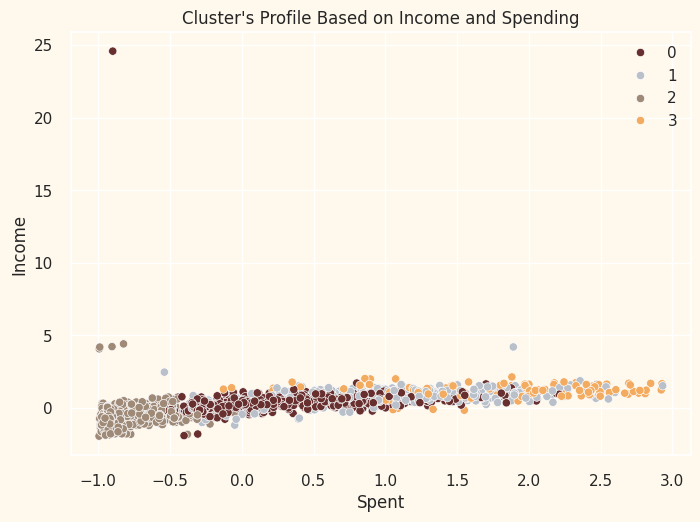

In [56]:
plt.figure()
pl = sns.scatterplot(data=data, x=data["Spent"], y=data["Income"], hue=data["Clusters"], palette=pal)
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.legend()
plt.show()

Additional analysis:

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 15.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 79.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-57-85db277f8838>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 25.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/

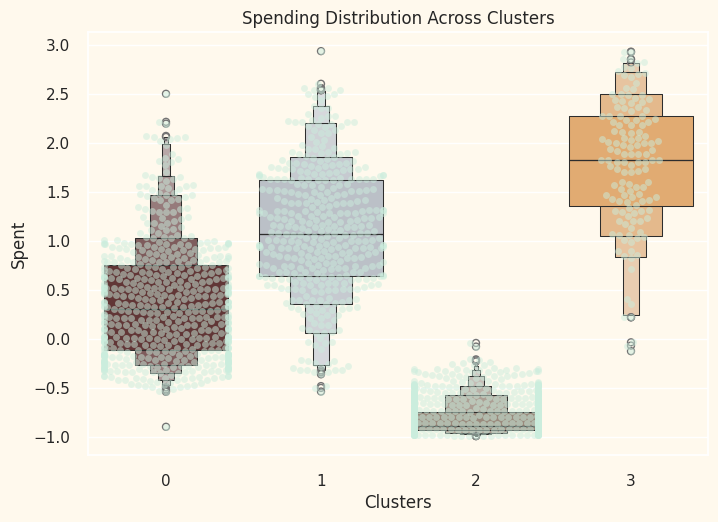

In [57]:
plt.figure()
pl = sns.swarmplot(x=data["Clusters"], y=data["Spent"], color="#CBEDDD", alpha=0.5)
pl = sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.title("Spending Distribution Across Clusters")
plt.show()

Evaluating  with Silhouette score:

In [58]:
silhouette_avg_kmeans = silhouette_score(PCA_ds, data['Clusters'])
print(f'K-Means Silhouette Score: {silhouette_avg_kmeans}')

K-Means Silhouette Score: 0.44201099851432485


Conclusion:

In [59]:
print("Cluster 0: High spending & average income")
print("Cluster 1: High spending & high income")
print("Cluster 2: Low spending & low income")
print("Cluster 3: High spending & low income")

Cluster 0: High spending & average income
Cluster 1: High spending & high income
Cluster 2: Low spending & low income
Cluster 3: High spending & low income


Converting it into a pickle format file:

In [60]:
import pickle

# Save the trained K-Means model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

# Save the scaler (if you're using a scaler to normalize input data)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)

print("Model and scaler saved as pickle files.")

Model and scaler saved as pickle files.


Prediction:

In [66]:
try:
    with open('kmeans_model.pkl', 'rb') as f:
        kmeans_model = pickle.load(f)
    print("K-Means model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")

# Load the scaler
try:
    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    print("Scaler loaded successfully.")
except Exception as e:
    print(f"Error loading scaler: {e}")

with open('pca.pkl', 'rb') as f:
    pca = pickle.load(f)
print("PCA loaded successfully.")

sample_data = np.array([[50000, 45, 6]])


# Make a prediction using the loaded K-Means model
predicted_cluster = kmeans_model.predict(sample_data)

# Display the predicted cluster
print(f"Predicted Cluster for the sample data: {predicted_cluster[0]}")

K-Means model loaded successfully.
Scaler loaded successfully.
PCA loaded successfully.
Predicted Cluster for the sample data: 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
